In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn.cluster import KMeans
import numpy as np

In [277]:
df = pd.read_csv("./data/Bold_744H-10_31-11_07.csv")
df.head()

,Time,Inj Gas Meter Volume Instantaneous,Inj Gas Meter Volume Setpoint,Inj Gas Valve Percent Open
0,10/31/2024 12:00:00 am,391.43520,375.0,27.17612
1,10/31/2024 12:14:00 am,402.52365,NaN,NaN
2,10/31/2024 12:30:00 am,380.72775,NaN,26.70198
3,10/31/2024 12:46:00 am,382.73955,NaN,NaN
4,10/31/2024 1:00:00 am,384.86595,375.0,26.70198


In [278]:
df.shape

(677, 4)

In [279]:
old_setpoint = df.iloc[0, 2]
old_percent_open = df.iloc[0, 3]

for i in range(0, df.shape[0]):
    current_setpoint = df.iloc[i, 2]
    current_percent_open = df.iloc[i, 3]
    if math.isnan(df.iloc[i, 1]):
        df.iloc[i, 1] = 0.0
    if math.isnan(current_setpoint):
        df.iloc[i, 2] = old_setpoint
    if math.isnan(current_percent_open):
        df.iloc[i, 3] = old_percent_open
    
    old_setpoint = df.iloc[i, 2]
    old_percent_open = df.iloc[i, 3]

In [280]:
df.head()

,Time,Inj Gas Meter Volume Instantaneous,Inj Gas Meter Volume Setpoint,Inj Gas Valve Percent Open
0,10/31/2024 12:00:00 am,391.43520,375.0,27.17612
1,10/31/2024 12:14:00 am,402.52365,375.0,27.17612
2,10/31/2024 12:30:00 am,380.72775,375.0,26.70198
3,10/31/2024 12:46:00 am,382.73955,375.0,26.70198
4,10/31/2024 1:00:00 am,384.86595,375.0,26.70198


In [281]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 677 entries, 0 to 676
Data columns (total 4 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Time                                677 non-null    object 
 1   Inj Gas Meter Volume Instantaneous  677 non-null    float64
 2   Inj Gas Meter Volume Setpoint       677 non-null    float64
 3   Inj Gas Valve Percent Open          677 non-null    float64
dtypes: float64(3), object(1)
memory usage: 21.3+ KB


In [282]:
df.describe()

,Inj Gas Meter Volume Instantaneous,Inj Gas Meter Volume Setpoint,Inj Gas Valve Percent Open
count,677.000000,677.0,677.000000
mean,356.988340,375.0,34.632537
std,70.040464,0.0,17.807582
min,0.000000,375.0,0.000000
25%,357.794850,375.0,27.478060
50%,374.232300,375.0,28.933010
75%,386.814450,375.0,32.676490
max,405.571950,375.0,100.000000


In [283]:
df.groupby(df["Inj Gas Meter Volume Setpoint"]).agg({"Inj Gas Valve Percent Open": ["mean"]})

,Inj Gas Valve Percent Open
,mean
Inj Gas Meter Volume Setpoint,
375.0,34.632537


In [284]:
dataset = []
X = [] # Current volume
y = [] # Valve open
for i in range(0, df.shape[0]):
    X.append(df.iloc[i, 1])
    y.append(df.iloc[i, 3])
    dataset.append([df.iloc[i, 1], df.iloc[i, 3]])

In [285]:
kmeans = kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(dataset)

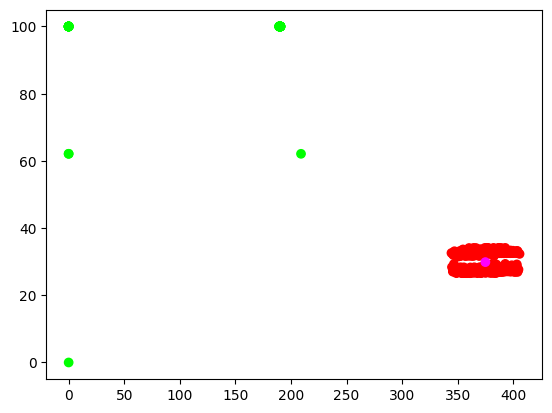

In [286]:
colors = []

for i in range(0, len(X)):
    point = [X[i].item(), y[i].item()]
    pred = kmeans.predict([point]).item()
    if pred == 0:
        colors.append("#FF0000")
    else:
        colors.append("#00FF00")

center_x = kmeans.cluster_centers_[0][0]
center_y = kmeans.cluster_centers_[0][1]
X.append(center_x)
y.append(center_y)
colors.append("#FF00FF")

plt.scatter(X, y, c=colors)

In [287]:
threshold = 100000

center_x = kmeans.cluster_centers_[0][0]
center_y = kmeans.cluster_centers_[0][1]

for k in range(0, 2):
    total = 0
    count = 0
    for i in range(0, len(X)):
        point = [X[i].item(), y[i].item()]
        pred = kmeans.predict([point]).item()
        distance = math.sqrt((point[0] - center_x) ** 2 + (point[1] - center_y) ** 2)
        if pred == 0 and distance < threshold:
            total += distance
            count += 1
    threshold = total / count
    
threshold
error_threshold = 4 * threshold

In [288]:
X_concern = []
y_concern = []
colors = []

df["Issue"] = 0
for i in range(0, len(X)):
    point = [X[i].item(), y[i].item()]
    if point[0] < center_x - error_threshold or point[1] > center_y + error_threshold:
        X_concern.append(point[0])
        y_concern.append(point[1])
        colors.append("#FF0000")
        df.iloc[i, 4] = 2.0
    elif point[0] < center_x - threshold or point[1] > center_y + threshold:
        X_concern.append(point[0])
        y_concern.append(point[1])
        colors.append("#FFFF00")
        df.iloc[i, 4] = 1.0

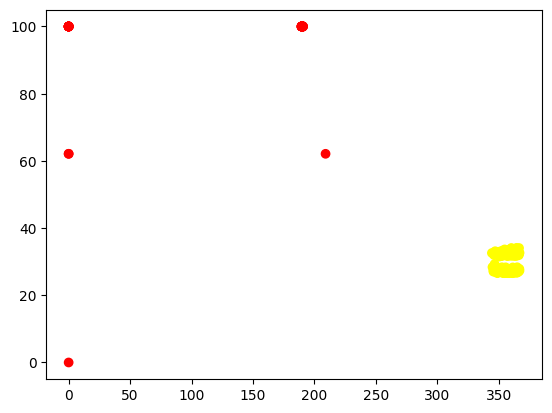

In [289]:
plt.scatter(X_concern, y_concern, c=colors)

In [303]:
warnings = df[(df["Issue"] == 2) | (df["Issue"] == 1)]
for i in range(0, df.shape[0]):
    print(f"{df.iloc[i,0]} ----- {df.iloc[i, 1]} ------  {df.iloc[i, 3]} ----- {df.iloc[i, 4]}")

10/31/2024 12:00:00 am ----- 391.4352 ------  27.17612 ----- 0
10/31/2024 12:14:00 am ----- 402.52365 ------  27.17612 ----- 0
10/31/2024 12:30:00 am ----- 380.72775 ------  26.70198 ----- 0
10/31/2024 12:46:00 am ----- 382.73955 ------  26.70198 ----- 0
10/31/2024 1:00:00 am ----- 384.86595 ------  26.70198 ----- 0
10/31/2024 1:14:00 am ----- 384.27975 ------  26.70198 ----- 0
10/31/2024 1:28:00 am ----- 383.2236 ------  26.70198 ----- 0
10/31/2024 1:44:00 am ----- 378.5196 ------  26.70198 ----- 0
10/31/2024 2:00:00 am ----- 374.74245 ------  26.70198 ----- 0
10/31/2024 2:14:00 am ----- 370.43145 ------  26.70198 ----- 0
10/31/2024 2:30:00 am ----- 364.6467 ------  26.70198 ----- 1
10/31/2024 2:46:00 am ----- 356.7471 ------  26.70198 ----- 1
10/31/2024 2:58:00 am ----- 348.91725 ------  26.77205 ----- 1
10/31/2024 3:14:00 am ----- 351.435 ------  31.71132 ----- 1
10/31/2024 3:28:00 am ----- 367.9839 ------  31.93819 ----- 0
10/31/2024 3:44:00 am ----- 360.4317 ------  31.93819 -----

In [304]:
df = pd.read_csv("./data/Courageous_729H-09_25-09_28.csv")
df.head()

,Time,Inj Gas Meter Volume Instantaneous,Inj Gas Meter Volume Setpoint,Inj Gas Valve Percent Open
0,09/25/2024 12:00:00 am,993.002150,NaN,43.640763
1,09/25/2024 12:02:00 am,979.919175,NaN,43.473800
2,09/25/2024 12:04:00 am,976.157250,NaN,NaN
3,09/25/2024 12:06:00 am,963.743400,973.5,43.473800
4,09/25/2024 12:08:00 am,945.198300,NaN,44.332660


In [305]:
old_setpoint = df.iloc[0, 2]
old_percent_open = df.iloc[0, 3]

for i in range(0, df.shape[0]):
    current_setpoint = df.iloc[i, 2]
    current_percent_open = df.iloc[i, 3]
    if math.isnan(df.iloc[i, 1]):
        df.iloc[i, 1] = 0.0
    if math.isnan(current_setpoint):
        df.iloc[i, 2] = old_setpoint
    if math.isnan(current_percent_open):
        df.iloc[i, 3] = old_percent_open
    
    old_setpoint = df.iloc[i, 2]
    old_percent_open = df.iloc[i, 3]

In [306]:
dataset = []
X = [] # Current volume
y = [] # Valve open
for i in range(0, df.shape[0]):
    X.append(df.iloc[i, 1])
    y.append(df.iloc[i, 3])
    dataset.append([df.iloc[i, 1], df.iloc[i, 3]])

In [307]:
kmeans = kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(dataset)

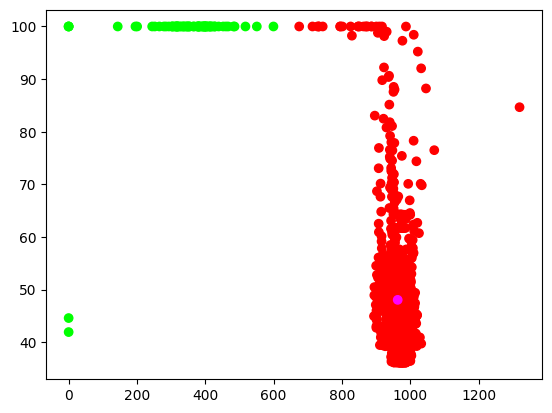

In [308]:
colors = []

for i in range(0, len(X)):
    point = [X[i].item(), y[i].item()]
    pred = kmeans.predict([point]).item()
    if pred == 0:
        colors.append("#FF0000")
    else:
        colors.append("#00FF00")

center_x = kmeans.cluster_centers_[0][0]
center_y = kmeans.cluster_centers_[0][1]
X.append(center_x)
y.append(center_y)
colors.append("#FF00FF")


plt.scatter(X, y, c=colors)

In [309]:
threshold = 100000

center_x = kmeans.cluster_centers_[0][0]
center_y = kmeans.cluster_centers_[0][1]

for k in range(0, 2):
    total = 0
    count = 0
    for i in range(0, len(X)):
        point = [X[i].item(), y[i].item()]
        pred = kmeans.predict([point]).item()
        distance = math.sqrt((point[0] - center_x) ** 2 + (point[1] - center_y) ** 2)
        if pred == 0 and distance < threshold:
            total += distance
            count += 1
    threshold = total / count
    
threshold
error_threshold = 4 * threshold

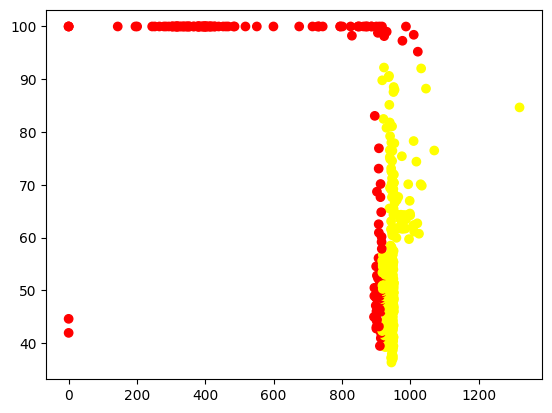

In [310]:
X_concern = []
y_concern = []
colors = []

df["Issue"] = 0
for i in range(0, len(X)):
    point = [X[i].item(), y[i].item()]
    if point[0] < center_x - error_threshold or point[1] > center_y + error_threshold:
        X_concern.append(point[0])
        y_concern.append(point[1])
        colors.append("#FF0000")
        df.iloc[i, 4] = 2.0
    elif point[0] < center_x - threshold or point[1] > center_y + threshold:
        X_concern.append(point[0])
        y_concern.append(point[1])
        colors.append("#FFFF00")
        df.iloc[i, 4] = 1.0

plt.scatter(X_concern, y_concern, c=colors)

In [311]:
warnings = df[(df["Issue"] == 2) | (df["Issue"] == 1)]
for i in range(0, df.shape[0]):
    print(f"{df.iloc[i,0]} ----- {df.iloc[i, 1]} ------  {df.iloc[i, 3]} ----- {df.iloc[i, 4]}")

09/25/2024 12:00:00 am ----- 993.0021499999996 ------  43.6407633333333 ----- 0
09/25/2024 12:02:00 am ----- 979.919175 ------  43.4738 ----- 0
09/25/2024 12:04:00 am ----- 976.15725 ------  43.4738 ----- 0
09/25/2024 12:06:00 am ----- 963.7434 ------  43.4738 ----- 0
09/25/2024 12:08:00 am ----- 945.1983 ------  44.33266 ----- 1
09/25/2024 12:12:00 am ----- 939.544575 ------  49.359535 ----- 1
09/25/2024 12:14:00 am ----- 965.904225 ------  51.36454 ----- 0
09/25/2024 12:16:00 am ----- 971.64525 ------  51.36454 ----- 0
09/25/2024 12:18:00 am ----- 968.4021 ------  51.36454 ----- 0
09/25/2024 12:20:00 am ----- 971.53935 ------  51.36454 ----- 0
09/25/2024 12:22:00 am ----- 982.63965 ------  51.36454 ----- 0
09/25/2024 12:24:00 am ----- 984.27795 ------  51.36454 ----- 0
09/25/2024 12:26:00 am ----- 990.134025 ------  51.36454 ----- 0
09/25/2024 12:28:00 am ----- 989.2005 ------  51.36454 ----- 0
09/25/2024 12:30:00 am ----- 985.114575 ------  51.36454 ----- 0
09/25/2024 12:32:00 am --

In [137]:
top = 0
bot = 0
center_x = kmeans.cluster_centers_[0][0]
center_y = kmeans.cluster_centers_[0][1]

for i in range(0, len(X)):
    point = [X[i].item(), y[i].item()]
    pred = kmeans.predict([point]).item()
    if pred == 0:
        if point[1] > center_y:
            top += 1
        else:
            bot += 1

print(top)
print(bot)

955
1064


In [124]:
highest = 0
lowest = 100

cluster_X = []
cluster_y = []
cluster_dataset = []

for i in range(0, len(X)):
    point = [X[i].item(), y[i].item()]
    pred = kmeans.predict([point]).item()
    if pred == 0:
        cluster_dataset.append(point)
        cluster_X.append(point[0])
        cluster_y.append(point[1])
        if point[1] > highest:
           highest = point[1]
        if point[1] < lowest:
           lowest = point[1]

distance = highest - lowest
distance

63.8592

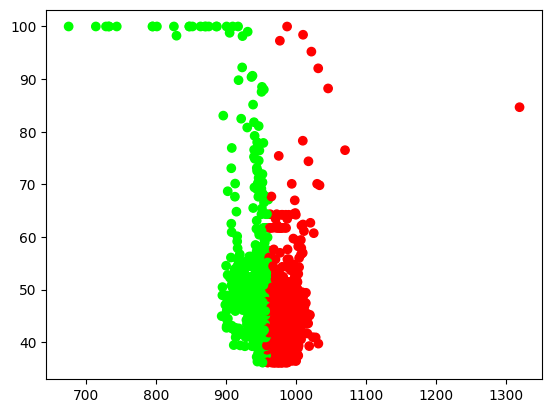

In [129]:
if distance > 30:
    colors = []
    mid = sum(cluster_X) / len(cluster_X)
    kmeans = kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto", init=[[mid, 0], [mid, 100]]).fit(cluster_dataset)
    for i in range(0, len(cluster_X)):
        point = [cluster_X[i], cluster_y[i]]
        pred = kmeans.predict([point]).item()
        if pred == 0:
            colors.append("#FF0000")
        else:
            colors.append("#00FF00")
    
    plt.scatter(cluster_X, cluster_y, c=colors)

In [239]:
df = pd.read_csv("./data/Fearless_709H-10_31-11_07.csv")
df.head()

,Time,Inj Gas Meter Volume Instantaneous,Inj Gas Meter Volume Setpoint,Inj Gas Valve Percent Open
0,10/31/2024 12:00:00 am,559.02255,543.0,44.65046
1,10/31/2024 12:14:00 am,549.63090,NaN,44.68318
2,10/31/2024 12:30:00 am,586.35675,NaN,44.58979
3,10/31/2024 12:46:00 am,573.30135,NaN,44.62712
4,10/31/2024 1:00:00 am,564.64830,543.0,44.64499


In [240]:
old_setpoint = df.iloc[0, 2]
old_percent_open = df.iloc[0, 3]

for i in range(0, df.shape[0]):
    current_setpoint = df.iloc[i, 2]
    current_percent_open = df.iloc[i, 3]
    if math.isnan(df.iloc[i, 1]):
        df.iloc[i, 1] = 0.0
    if math.isnan(current_setpoint):
        df.iloc[i, 2] = old_setpoint
    if math.isnan(current_percent_open):
        df.iloc[i, 3] = old_percent_open
    
    old_setpoint = df.iloc[i, 2]
    old_percent_open = df.iloc[i, 3]

In [241]:
dataset = []
X = [] # Current volume
y = [] # Valve open
for i in range(0, df.shape[0]):
    X.append(df.iloc[i, 1])
    y.append(df.iloc[i, 3])
    dataset.append([df.iloc[i, 1], df.iloc[i, 3]])

In [242]:
kmeans = kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(dataset)

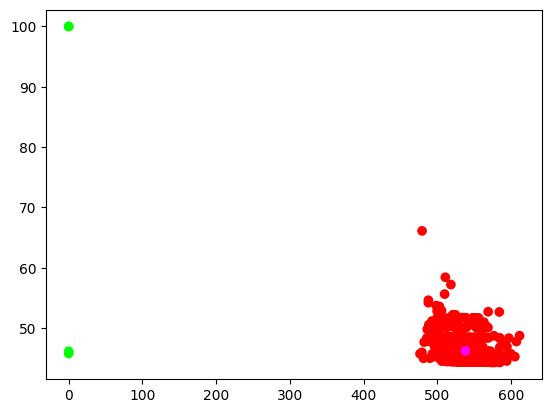

In [243]:
colors = []

for i in range(0, len(X)):
    point = [X[i].item(), y[i].item()]
    pred = kmeans.predict([point]).item()
    if pred == 0:
        colors.append("#FF0000")
    else:
        colors.append("#00FF00")

center_x = kmeans.cluster_centers_[0][0]
center_y = kmeans.cluster_centers_[0][1]
X.append(center_x)
y.append(center_y)
colors.append("#FF00FF")


plt.scatter(X, y, c=colors)

In [245]:
threshold = 100000

center_x = kmeans.cluster_centers_[0][0]
center_y = kmeans.cluster_centers_[0][1]

for k in range(0, 1):
    total = 0
    count = 0
    for i in range(0, len(X)):
        point = [X[i].item(), y[i].item()]
        pred = kmeans.predict([point]).item()
        distance = math.sqrt((point[0] - center_x) ** 2 + (point[1] - center_y) ** 2)
        if pred == 0 and distance < threshold:
            total += distance
            count += 1
    threshold = total / count

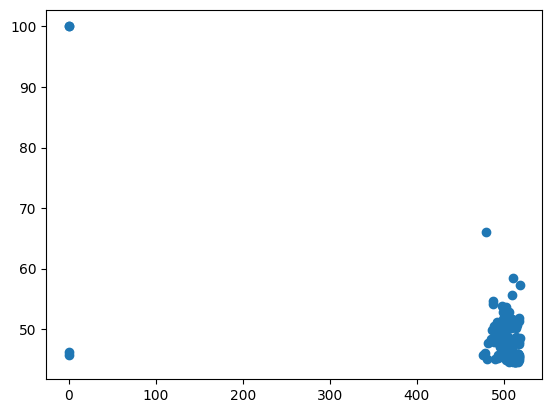

In [246]:
X_concern = []
y_concern = []

for i in range(0, len(X)):
    point = [X[i].item(), y[i].item()]
    if point[0] < center_x - threshold or point[1] > center_y + threshold:
        X_concern.append(point[0])
        y_concern.append(point[1])
        
plt.scatter(X_concern, y_concern)

In [164]:
df = pd.read_csv("./data/Gallant_102H-10_04-10_11.csv")
df.head()

,Time,Inj Gas Meter Volume Instantaneous,Inj Gas Meter Volume Setpoint,Inj Gas Valve Percent Open
0,10/04/2024 12:02:00 am,769.617750,NaN,43.854185
1,10/04/2024 12:04:00 am,770.582650,NaN,43.850995
2,10/04/2024 12:06:00 am,771.192900,750.0,43.850595
3,10/04/2024 12:08:00 am,771.011100,NaN,43.850210
4,10/04/2024 12:10:00 am,771.673725,NaN,43.847920


In [165]:
old_setpoint = df.iloc[0, 2]
old_percent_open = df.iloc[0, 3]

for i in range(0, df.shape[0]):
    current_setpoint = df.iloc[i, 2]
    current_percent_open = df.iloc[i, 3]
    if math.isnan(df.iloc[i, 1]):
        df.iloc[i, 1] = 0.0
    if math.isnan(current_setpoint):
        df.iloc[i, 2] = old_setpoint
    if math.isnan(current_percent_open):
        df.iloc[i, 3] = old_percent_open
    
    old_setpoint = df.iloc[i, 2]
    old_percent_open = df.iloc[i, 3]

In [166]:
dataset = []
X = [] # Current volume
y = [] # Valve open
for i in range(0, df.shape[0]):
    X.append(df.iloc[i, 1])
    y.append(df.iloc[i, 3])
    dataset.append([df.iloc[i, 1], df.iloc[i, 3]])

In [167]:
kmeans = kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(dataset)

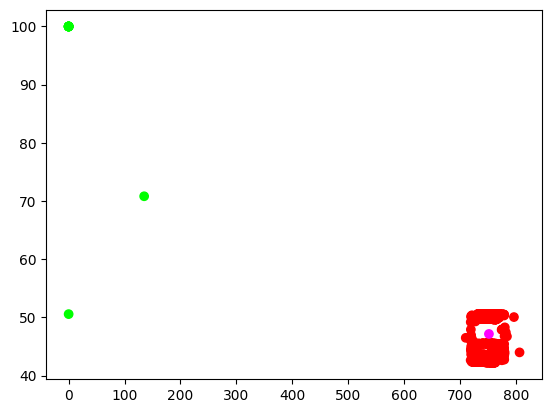

In [168]:
colors = []

for i in range(0, len(X)):
    point = [X[i].item(), y[i].item()]
    pred = kmeans.predict([point]).item()
    if pred == 0:
        colors.append("#FF0000")
    else:
        colors.append("#00FF00")

center_x = kmeans.cluster_centers_[0][0]
center_y = kmeans.cluster_centers_[0][1]
X.append(center_x)
y.append(center_y)
colors.append("#FF00FF")


plt.scatter(X, y, c=colors)

In [169]:
df = pd.read_csv("./data/Noble_4H-10_24-10_29.csv")
df.head()

,Time,Inj Gas Meter Volume Instantaneous,Inj Gas Meter Volume Setpoint,Inj Gas Valve Percent Open
0,10/24/2024 12:02:00 am,1194.800625,NaN,36.861895
1,10/24/2024 12:04:00 am,1199.565300,NaN,37.902420
2,10/24/2024 12:06:00 am,NaN,1200.0,NaN
3,10/24/2024 12:08:00 am,1193.520600,NaN,39.708210
4,10/24/2024 12:10:00 am,1204.110750,NaN,38.294660


In [170]:
old_setpoint = df.iloc[0, 2]
old_percent_open = df.iloc[0, 3]

for i in range(0, df.shape[0]):
    current_setpoint = df.iloc[i, 2]
    current_percent_open = df.iloc[i, 3]
    if math.isnan(df.iloc[i, 1]):
        df.iloc[i, 1] = 0.0
    if math.isnan(current_setpoint):
        df.iloc[i, 2] = old_setpoint
    if math.isnan(current_percent_open):
        df.iloc[i, 3] = old_percent_open
    
    old_setpoint = df.iloc[i, 2]
    old_percent_open = df.iloc[i, 3]

In [171]:
dataset = []
X = [] # Current volume
y = [] # Valve open
for i in range(0, df.shape[0]):
    X.append(df.iloc[i, 1])
    y.append(df.iloc[i, 3])
    dataset.append([df.iloc[i, 1], df.iloc[i, 3]])

In [172]:
kmeans = kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(dataset)

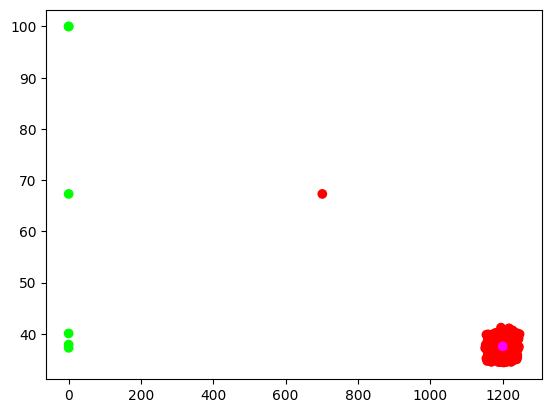

In [173]:
colors = []

for i in range(0, len(X)):
    point = [X[i].item(), y[i].item()]
    pred = kmeans.predict([point]).item()
    if pred == 0:
        colors.append("#FF0000")
    else:
        colors.append("#00FF00")

center_x = kmeans.cluster_centers_[0][0]
center_y = kmeans.cluster_centers_[0][1]
X.append(center_x)
y.append(center_y)
colors.append("#FF00FF")


plt.scatter(X, y, c=colors)